In [1]:
import numpy as np

from scipy.interpolate import Rbf, interp1d
from scipy.integrate import quad
import matplotlib.pylab as plt

import ghalton

from fakequadrature import quadrature_weights

In [2]:
f=lambda x: 1/(1+4*x**2)
a,b = -2,2

In [3]:
I_True, _ = quad(f,a,b, epsabs = 1.e-10)

In [4]:
I_True

1.3258176636680323

In [5]:
rbf = lambda self,r: np.exp(-self.epsilon*r)*(1+self.epsilon*r)
ep = 1.e-1

In [6]:
G = ghalton.GeneralizedHalton(1, 42)

In [7]:
deg = 40


In [8]:
Degrees = np.arange(6,62,2)

In [9]:
errCL, errH, err1, err2 = [], [], [], []
for deg in Degrees:
    n = int(deg + 1)

    # Halton nodes in [-2,2]
    x = 4 * np.array([0.]+ sorted([a[0] for a in G.get(n-2)]) + [1.]) - 2
    y = f(x)
    # Chebyshev-Lobatto nodes in [-2,2]
    xCL = -(b-a)/2*np.cos(np.arange(0,deg+1)*np.pi/deg)+(a+b)/2
    yCL = f(xCL)


    S1 = Rbf(x, xCL, function=rbf)
    S2 = interp1d(x, xCL, kind = 'linear')

    # quadrature on CL nodes
    wCL = quadrature_weights(xCL,(a,b))
    ICL = np.dot(wCL, yCL)
    errCL.append(np.abs(I_True - ICL))

    # quadrature on Halton Nodes
    wH = quadrature_weights(x,(a,b))
    IH = np.dot(wH, y)
    errH.append(np.abs(I_True - IH))

    # quadrature on Fake-CL nodes
    w1 = quadrature_weights(x,(a,b), mapping=S1)
    I1 = np.dot(w1,y)
    err1.append(np.abs(I_True - I1))

    w2 = quadrature_weights(x,(a,b), mapping=S2)
    I2 = np.dot(w2,y)
    err2.append(np.abs(I_True - I2))

/Users/poggiali/GitHub/FakeQuadrature/fakequadrature.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  weights = [ quad( funcf, a, b, epsabs = 1.e-9, limit=250, args=(k,))[0] for k in range(N_nodes) ]
/Users/poggiali/GitHub/FakeQuadrature/fakequadrature.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  weights = [ quad( funcf, a, b, epsabs = 1.e-9, limit=250, args=(k,))[0] for k in range(N_nodes) ]


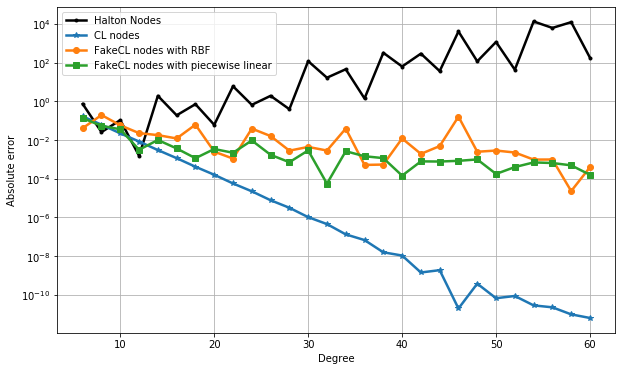

In [11]:
plt.figure(figsize=(10,6))
plt.semilogy(Degrees, errH,'.-k', linewidth=2.5)
plt.semilogy(Degrees, errCL,'*-', linewidth=2.5)
plt.semilogy(Degrees, err1,'o-', linewidth=2.5)
plt.semilogy(Degrees, err2,'s-', linewidth=2.5)
plt.xlabel("Degree")
plt.ylabel("Absolute error")
plt.legend(["Halton Nodes", "CL nodes", "FakeCL nodes with RBF", "FakeCL nodes with piecewise linear"])
plt.grid()

plt.savefig("figRunge.pdf")